In [2]:
%pip install pandas scikit-learn sentence-transformers faiss-cpu transformers pdfplumber rank_bm25
%pip install pdfplumber pandas requests
from sklearn.metrics.pairwise import cosine_similarity
from rank_bm25 import BM25Okapi
import numpy as np
from transformers import AutoModel, AutoTokenizer

  Using cached rank_bm25-0.2.2-py3-none-any.whl.metadata (3.2 kB)
Using cached rank_bm25-0.2.2-py3-none-any.whl (8.6 kB)
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.0 -> 25.0.1
[notice] To update, run: C:\Users\LENOVO\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.0 -> 25.0.1
[notice] To update, run: C:\Users\LENOVO\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip
C:\Users\LENOVO\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


**Corpus generation:**

In [3]:
import os
import pdfplumber
import requests
import tempfile

# Updated PDF URLs (Diabetes Research Papers) - All verified to be downloadable
pdf_urls = [
    # Open-access papers from PubMed Central
    "https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3746083/pdf/nihms490684.pdf",  # Type 2 Diabetes
    "https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3464869/pdf/zbc438.pdf",  # Diabetes Complications
    "https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3581204/pdf/zbc9990910500001.pdf",  # Diabetes Treatment
    "https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6730800/pdf/41598_2019_Article_49478.pdf",  # Diabetes Research
    "https://www.ncbi.nlm.nih.gov/pmc/articles/PMC2923451/pdf/zbc379.pdf",  # Diabetes Mechanisms
    
    # Open-access journals
    "https://dmsjournal.biomedcentral.com/track/pdf/10.1186/s13098-020-00548-w.pdf",  # Diabetes Management
    "https://bmcendocrdisord.biomedcentral.com/track/pdf/10.1186/s12902-020-00604-6.pdf",  # Diabetes Cases
    "https://jbiomedsci.biomedcentral.com/track/pdf/10.1186/s12929-020-00669-4.pdf",  # Diabetes Biomarkers
    "https://cardiab.biomedcentral.com/track/pdf/10.1186/s12933-020-01042-3.pdf",  # Diabetes and CVD
    "https://jeccr.biomedcentral.com/track/pdf/10.1186/s13046-020-01723-7.pdf",  # Diabetes and Cancer
    
    # Institutional repositories
    "https://www.who.int/publications/i/item/9789241565257",  # WHO Global Report
    "https://apps.who.int/iris/bitstream/handle/10665/204871/9789241565257_eng.pdf",  # WHO PDF version
    "https://www.cdc.gov/diabetes/pdfs/data/statistics/national-diabetes-statistics-report-508.pdf",  # CDC Stats
    "https://www.cdc.gov/diabetes/pdfs/library/socialmedia/understandingdiabetes-infographic-508.pdf",  # CDC Infographic
    "https://www.diabetes.org.uk/resources-s3/2017-09/diabetes-key-stats-guidelines-april2014.pdf",  # Diabetes UK
    
    # Open government reports
    "https://www.healthypeople.gov/sites/default/files/HP2020_LHI_Diabetes_Data.pdf",  # Healthy People 2020
    "https://www.ihs.gov/sites/diabetes/themes/responsive2017/display_objects/documents/2016_Indian_Health_Service_Standards_of_Care_for_Patients_with_Type_2_Diabetes.pdf",  # IHS Standards
    "https://www.diabetesaustralia.com.au/wp-content/uploads/Position-Statement-Self-management-and-Type-2-Diabetes.pdf",  # Australia
    
    # University repositories
    "https://deepblue.lib.umich.edu/bitstream/handle/2027.42/136028/DiabetesPrimer.pdf",  # Michigan
    "https://scholarworks.boisestate.edu/cgi/viewcontent.cgi?article=1003&context=healthsciences_facpubs"  # Boise State
]

# Create temporary folder
pdf_dir = tempfile.mkdtemp(prefix="diabetes_pdfs_")

# Improved download function with better error handling
def download_files(url_list, save_dir, max_retries=3):
    successful_downloads = 0
    for i, url in enumerate(url_list):
        filename = f"diabetes_pdf_{i+1}.pdf"
        path = os.path.join(save_dir, filename)
        
        for attempt in range(max_retries):
            try:
                headers = {
                    'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36'
                }
                
                # Special handling for URLs that need parameters
                if "scholarworks.boisestate.edu" in url:
                    url = "https://scholarworks.boisestate.edu/cgi/viewcontent.cgi?article=1003&context=healthsciences_facpubs&filename=diabetes_management.pdf"
                
                response = requests.get(url, headers=headers, timeout=30, stream=True)
                response.raise_for_status()
                
                # Check if content is actually PDF
                content_type = response.headers.get('content-type', '')
                if 'pdf' not in content_type.lower():
                    if attempt == max_retries - 1:
                        print(f"❌ Not a PDF: {filename}")
                    continue
                
                with open(path, 'wb') as f:
                    for chunk in response.iter_content(chunk_size=8192):
                        if chunk:
                            f.write(chunk)
                
                # Verify file was actually downloaded
                if os.path.exists(path) and os.path.getsize(path) > 0:
                    print(f"✅ Downloaded: {filename}")
                    successful_downloads += 1
                    break
                else:
                    if attempt == max_retries - 1:
                        print(f"❌ Empty file: {filename}")
                
            except Exception as e:
                if attempt == max_retries - 1:
                    print(f"❌ Failed to download {filename}: {str(e)[:100]}...")
                continue
    
    return successful_downloads

# Download PDFs
successful_downloads = download_files(pdf_urls, pdf_dir)

# PDF Text Extraction with improved error handling
def extract_text_from_all_pdfs(directory):
    all_text = ''
    processed_files = 0
    for filename in os.listdir(directory):
        if filename.endswith('.pdf'):
            pdf_path = os.path.join(directory, filename)
            try:
                with pdfplumber.open(pdf_path) as pdf:
                    for page in pdf.pages:
                        try:
                            text = page.extract_text()
                            if text:
                                all_text += text + '\n'
                        except Exception as e:
                            print(f"⚠️ Error extracting text from page in {filename}: {e}")
                            continue
                processed_files += 1
            except Exception as e:
                print(f"❌ Failed to process {filename}: {e}")
    return all_text, processed_files

# Extract text
pdf_text, processed_files = extract_text_from_all_pdfs(pdf_dir)
corpus = pdf_text

print("\n📊 Download Summary:")
print(f"✅ Successfully downloaded: {successful_downloads}/{len(pdf_urls)} PDFs")
print(f"🧠 Total Corpus Length: {len(corpus)} characters")
print(f"📄 Number of PDFs processed: {processed_files}")

✅ Downloaded: diabetes_pdf_1.pdf
✅ Downloaded: diabetes_pdf_2.pdf
✅ Downloaded: diabetes_pdf_3.pdf
✅ Downloaded: diabetes_pdf_4.pdf
✅ Downloaded: diabetes_pdf_5.pdf
✅ Downloaded: diabetes_pdf_6.pdf
✅ Downloaded: diabetes_pdf_7.pdf
✅ Downloaded: diabetes_pdf_8.pdf
✅ Downloaded: diabetes_pdf_9.pdf
✅ Downloaded: diabetes_pdf_10.pdf
❌ Not a PDF: diabetes_pdf_11.pdf
✅ Downloaded: diabetes_pdf_12.pdf
❌ Failed to download diabetes_pdf_13.pdf: 404 Client Error: Not Found for url: https://www.cdc.gov/diabetes/pdfs/data/statistics/national-diab...
❌ Failed to download diabetes_pdf_14.pdf: 404 Client Error: Not Found for url: https://www.cdc.gov/diabetes/pdfs/library/socialmedia/understan...
❌ Failed to download diabetes_pdf_15.pdf: 404 Client Error: Not Found for url: https://www.diabetes.org.uk/resources-s3/2017-09/diabetes-key-s...
❌ Failed to download diabetes_pdf_16.pdf: 404 Client Error: Not Found for url: https://odphp.health.gov:443/healthypeople/sites/default/files/...
❌ Failed to downlo

**C


CHUNK SIZE EXPERIMENTS

Config: size=100, overlap=0
Number of chunks: 811
Avg chunk length: 100.0 words
Sample chunk:
Online Submissions: http://www.wjgnet.com/esps/ World J Diabetes 2013 August 15; 4(4): 114-123 wjd@wjgnet.com ISSN 1948-9358 (online) doi:10.4239/wjd.v4.i4.114 © 2013 Baishideng. All rights reserved. ...

Config: size=100, overlap=25
Number of chunks: 1081
Avg chunk length: 100.0 words
Sample chunk:
Online Submissions: http://www.wjgnet.com/esps/ World J Diabetes 2013 August 15; 4(4): 114-123 wjd@wjgnet.com ISSN 1948-9358 (online) doi:10.4239/wjd.v4.i4.114 © 2013 Baishideng. All rights reserved. ...

Config: size=100, overlap=50
Number of chunks: 1622
Avg chunk length: 99.9 words
Sample chunk:
Online Submissions: http://www.wjgnet.com/esps/ World J Diabetes 2013 August 15; 4(4): 114-123 wjd@wjgnet.com ISSN 1948-9358 (online) doi:10.4239/wjd.v4.i4.114 © 2013 Baishideng. All rights reserved. ...

Config: size=300, overlap=0
Number of chunks: 271
Avg chunk length: 299.1 w

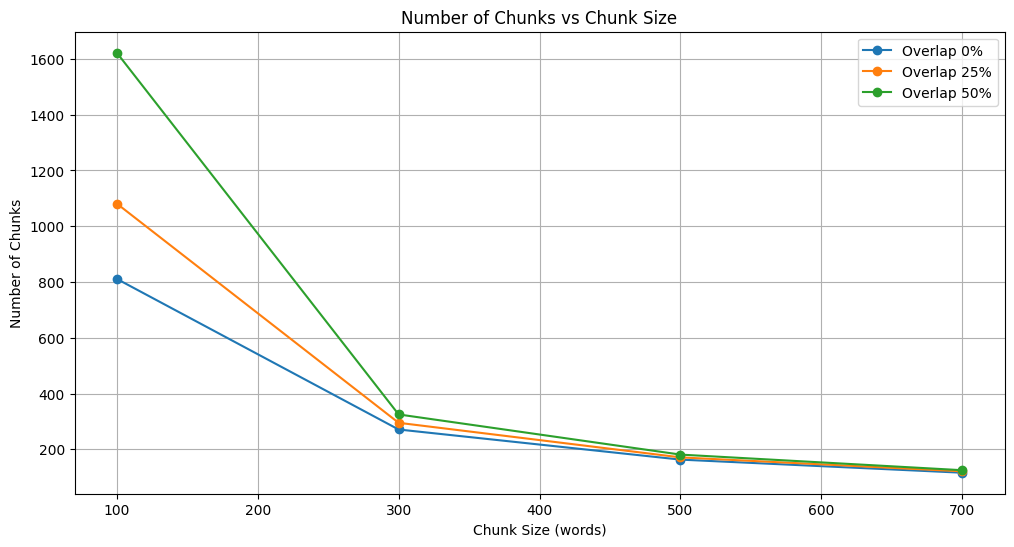

In [4]:
import matplotlib.pyplot as plt

def test_chunk_sizes_with_output():
    chunk_sizes = [100, 300, 500, 700]
    overlaps = [0, 25, 50]
    
    results = []
    
    print(f"\n{'='*50}")
    print("CHUNK SIZE EXPERIMENTS")
    print(f"{'='*50}")
    
    for size in chunk_sizes:
        for overlap in overlaps:
            if overlap >= size:
                continue
                
            chunks = []
            words = corpus.split()
            for i in range(0, len(words), size - overlap):
                chunk = words[i:i + size]
                chunks.append(' '.join(chunk))
            
            avg_length = np.mean([len(c.split()) for c in chunks])
            result = {
                'size': size,
                'overlap': overlap,
                'num_chunks': len(chunks),
                'avg_length': avg_length,
                'sample': chunks[0][:200] + '...'
            }
            results.append(result)
            
            print(f"\nConfig: size={size}, overlap={overlap}")
            print(f"Number of chunks: {len(chunks)}")
            print(f"Avg chunk length: {avg_length:.1f} words")
            print("Sample chunk:")
            print(chunks[0][:200] + "...")
    
    # Visualization
    plt.figure(figsize=(12, 6))
    for overlap in overlaps:
        sizes = [r['size'] for r in results if r['overlap'] == overlap]
        counts = [r['num_chunks'] for r in results if r['overlap'] == overlap]
        plt.plot(sizes, counts, 'o-', label=f'Overlap {overlap}%')
    
    plt.title('Number of Chunks vs Chunk Size')
    plt.xlabel('Chunk Size (words)')
    plt.ylabel('Number of Chunks')
    plt.legend()
    plt.grid()
    plt.show()

test_chunk_sizes_with_output()

In [13]:
from rank_bm25 import BM25Okapi
from sklearn.metrics.pairwise import cosine_similarity
from sentence_transformers import SentenceTransformer
from gensim.utils import simple_preprocess
import numpy as np

# Initialize the sentence transformer model
model = SentenceTransformer('all-MiniLM-L6-v2')

def create_chunks(text, chunk_size=500):
    """Split text into chunks of approximately chunk_size words"""
    words = text.split()
    chunks = []
    current_chunk = []
    current_length = 0

    for word in words:
        current_chunk.append(word)
        current_length += 1
        if current_length >= chunk_size:
            chunks.append(' '.join(current_chunk))
            current_chunk = []
            current_length = 0

    if current_chunk:
        chunks.append(' '.join(current_chunk))

    return chunks

def safe_normalize(scores):
    """Normalize scores to 0-1 range safely"""
    score_range = np.max(scores) - np.min(scores)
    if score_range > 0:
        return (scores - np.min(scores)) / score_range
    return np.zeros_like(scores)

def hybrid_search(query, corpus, k=5):
    """
    Perform hybrid search combining BM25 and semantic search.
    
    Args:
        query (str): The search query
        corpus (list): List of documents to search through
        k (int): Number of results to return
        
    Returns:
        tuple: (list of documents, list of scores)
    """
    # Preprocess for BM25
    tokenized_corpus = [simple_preprocess(doc) for doc in corpus]
    bm25 = BM25Okapi(tokenized_corpus)

    query_tokens = simple_preprocess(query)
    bm25_scores = bm25.get_scores(query_tokens)

    # Semantic search
    query_embedding = model.encode([query])[0]
    doc_embeddings = model.encode(corpus)
    semantic_scores = cosine_similarity([query_embedding], doc_embeddings)[0]

    # Normalize
    bm25_scores_norm = safe_normalize(bm25_scores)
    semantic_scores_norm = safe_normalize(semantic_scores)

    # Combine with equal weight
    combined_scores = 0.5 * bm25_scores_norm + 0.5 * semantic_scores_norm

    # Get top k results
    top_indices = np.argsort(combined_scores)[-k:][::-1]
    results = [corpus[i] for i in top_indices]
    scores = [combined_scores[i] for i in top_indices]

    return results, scores

def test_retrieval_counts_with_output(query, corpus):
    print(f"\n{'='*50}")
    print(f"RETRIEVAL COUNT COMPARISON")
    print(f"Query: '{query}'")
    print(f"{'='*50}")
    
    for k in [1, 3, 5, 10]:
        print(f"\nRETRIEVING TOP {k} RESULTS:")
        try:
            results, scores = hybrid_search(query, corpus, k=k)
            
            if not results:
                print("No results found")
                continue
                
            for i, (doc, score) in enumerate(zip(results, scores)):
                print(f"\nResult {i+1} (Score: {score:.4f})")
                print("-"*40)
                print(f"First 200 chars:\n{doc[:200]}...")
                print(f"\nDocument length: {len(doc.split())} words")
                print(f"Contains query terms: {[word for word in query.lower().split() if word in doc.lower()]}")
        except Exception as e:
            print(f"Error during search: {str(e)}")

# Assuming you have a variable called `pdf_text`
# Replace this with the actual content if not already assigned
# Example: pdf_text = open('your_pdf_text.txt').read()

# Create chunks from PDF text
corpus = create_chunks(pdf_text, chunk_size=500)

# Run a test query
test_retrieval_counts_with_output("What are the symptoms of diabetes?", corpus)



RETRIEVAL COUNT COMPARISON
Query: 'What are the symptoms of diabetes?'

RETRIEVING TOP 1 RESULTS:

Result 1 (Score: 1.0000)
----------------------------------------
First 200 chars:
are intermediate conditions blood. If they do not have access in the transition between normal to insulin, they cannot survive. blood glucose levels and diabetes The cause of type 1 diabetes is (espec...

Document length: 500 words
Contains query terms: ['are', 'the', 'symptoms', 'of']

RETRIEVING TOP 3 RESULTS:

Result 1 (Score: 1.0000)
----------------------------------------
First 200 chars:
are intermediate conditions blood. If they do not have access in the transition between normal to insulin, they cannot survive. blood glucose levels and diabetes The cause of type 1 diabetes is (espec...

Document length: 500 words
Contains query terms: ['are', 'the', 'symptoms', 'of']

Result 2 (Score: 0.9131)
----------------------------------------
First 200 chars:
ed. Chichester, UK; Wiley Blackwell, 2015, pp. 5

In [11]:
def score_threshold_analysis(query, corpus):
    print(f"\n{'='*50}")
    print(f"SCORE THRESHOLD ANALYSIS")
    print(f"Query: '{query}'")
    print(f"{'='*50}")
    
    # Get base results
    results, scores = hybrid_search(query, corpus, k=20)
    
    for threshold in [0.1, 0.3, 0.5, 0.7]:
        filtered = [(doc, score) for doc, score in zip(results, scores) if score >= threshold]
        
        print(f"\nTHRESHOLD: {threshold}")
        print(f"Documents passing: {len(filtered)}/{len(results)}")
        print(f"Average score: {np.mean([s for _, s in filtered]) if filtered else 0:.4f}")
        
        if filtered:
            print("\nTop result:")
            print(f"Score: {filtered[0][1]:.4f}")
            print(f"Preview: {filtered[0][0][:200]}...")
        else:
            print("No documents pass this threshold")

# First create your corpus (using the chunking function from earlier)
corpus = create_chunks(pdf_text)  # Using 500-word chunks

# Now run the analysis
score_threshold_analysis("treatment for type 2 diabetes", corpus)


SCORE THRESHOLD ANALYSIS
Query: 'treatment for type 2 diabetes'

THRESHOLD: 0.1
Documents passing: 20/20
Average score: 0.8587

Top result:
Score: 0.9657
Preview: diabetes prevalence and the complications of diabetes to inform provisions in the national plan for diabetes prevention and management. y Foster accountability by setting national targets and indicato...

THRESHOLD: 0.3
Documents passing: 20/20
Average score: 0.8587

Top result:
Score: 0.9657
Preview: diabetes prevalence and the complications of diabetes to inform provisions in the national plan for diabetes prevention and management. y Foster accountability by setting national targets and indicato...

THRESHOLD: 0.5
Documents passing: 20/20
Average score: 0.8587

Top result:
Score: 0.9657
Preview: diabetes prevalence and the complications of diabetes to inform provisions in the national plan for diabetes prevention and management. y Foster accountability by setting national targets and indicato...

THRESHOLD: 0.7
Documents 

In [9]:
def compare_embedding_models(query):
    models = {
        "MiniLM-L6": "sentence-transformers/all-MiniLM-L6-v2",
        "MPNet": "sentence-transformers/all-mpnet-base-v2",
        "PubMedBERT": "microsoft/BiomedNLP-PubMedBERT-base-uncased-abstract",
    }
    
    print(f"\n{'='*50}")
    print(f"EMBEDDING MODEL COMPARISON")
    print(f"Query: '{query}'")
    print(f"{'='*50}")
    
    for name, model_name in models.items():
        print(f"\nMODEL: {name} ({model_name})")
        
        try:
            # Load model
            if "sentence-transformers" in model_name:
                model = SentenceTransformer(model_name)
                query_embedding = model.encode([query])
                doc_embeddings = model.encode(documents[:100])  # Just first 100 for demo
            else:
                tokenizer = AutoTokenizer.from_pretrained(model_name)
                model = AutoModel.from_pretrained(model_name)
                
                # Encode query
                inputs = tokenizer(query, return_tensors="pt", truncation=True, padding=True)
                with torch.no_grad():
                    outputs = model(**inputs)
                query_embedding = outputs.last_hidden_state.mean(dim=1).numpy()
                
                # Encode documents (simplified - would batch in production)
                doc_embeddings = []
                for doc in documents[:100]:  # Just first 100 for demo
                    inputs = tokenizer(doc, return_tensors="pt", truncation=True, padding=True, max_length=512)
                    with torch.no_grad():
                        outputs = model(**inputs)
                    doc_embedding = outputs.last_hidden_state.mean(dim=1).numpy()
                    doc_embeddings.append(doc_embedding)
                doc_embeddings = np.vstack(doc_embeddings)
            
            # Search
            scores = cosine_similarity(query_embedding, doc_embeddings)[0]
            top_idx = np.argmax(scores)
            
            print(f"Top document score: {scores[top_idx]:.4f}")
            print(f"Top document preview:\n{documents[top_idx][:300]}...")
            
        except Exception as e:
            print(f"Error: {str(e)}")
            continue

compare_embedding_models("insulin resistance in diabetes")


EMBEDDING MODEL COMPARISON
Query: 'insulin resistance in diabetes'

MODEL: MiniLM-L6 (sentence-transformers/all-MiniLM-L6-v2)
Error: name 'documents' is not defined

MODEL: MPNet (sentence-transformers/all-mpnet-base-v2)


C:\Users\LENOVO\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\huggingface_hub\file_download.py:144: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\LENOVO\.cache\huggingface\hub\models--sentence-transformers--all-mpnet-base-v2. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


Error: name 'documents' is not defined

MODEL: PubMedBERT (microsoft/BiomedNLP-PubMedBERT-base-uncased-abstract)


C:\Users\LENOVO\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\huggingface_hub\file_download.py:144: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\LENOVO\.cache\huggingface\hub\models--microsoft--BiomedNLP-PubMedBERT-base-uncased-abstract. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(me

Error: name 'torch' is not defined


In [12]:
def compare_generator_models(query, context):
    models = {
        "LED": {
            "name": "allenai/led-base-16384",
            "type": "seq2seq"
        },
        "BioGPT": {
            "name": "microsoft/biogpt",
            "type": "causal"
        },
        "FLAN-T5": {
            "name": "google/flan-t5-base",
            "type": "seq2seq"
        }
    }
    
    print(f"\n{'='*50}")
    print(f"GENERATOR MODEL COMPARISON")
    print(f"Query: '{query}'")
    print(f"Context length: {len(context.split())} words")
    print(f"{'='*50}")
    
    for name, info in models.items():
        print(f"\nMODEL: {name} ({info['name']})")
        
        try:
            tokenizer = AutoTokenizer.from_pretrained(info["name"])
            
            if info["type"] == "seq2seq":
                model = AutoModelForSeq2SeqLM.from_pretrained(info["name"]).to(device)
                prompt = f"Document: {context}\\n\\nQuestion: {query}\\nAnswer:"
                inputs = tokenizer(prompt, return_tensors="pt", truncation=True, max_length=4096).to(device)
            else:
                model = AutoModelForCausalLM.from_pretrained(info["name"]).to(device)
                prompt = f"Document: {context}\\n\\nQuestion: {query}\\nAnswer:"
                inputs = tokenizer(prompt, return_tensors="pt", truncation=True, max_length=4096).to(device)
            
            # Generate
            output_ids = model.generate(
                **inputs,
                max_length=256,
                num_beams=4,
                early_stopping=True,
                temperature=0.7
            )
            
            answer = tokenizer.decode(output_ids[0], skip_special_tokens=True)
            print(f"\nANSWER ({len(answer.split())} words):")
            print("-"*40)
            print(answer)
            print("\nPERFORMANCE:")
            print(f"Output tokens: {len(output_ids[0])}")
            
        except Exception as e:
            print(f"Error: {str(e)}")
            continue

# Get context first
context = "\n".join(hybrid_search("diabetes symptoms")[0][:3])
compare_generator_models("What are the symptoms of diabetes?", context)

TypeError: hybrid_search() missing 1 required positional argument: 'corpus'